<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S9_Assignment(GradCAM%26Albumentations).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pip install Albumentation Library**

In [1]:
from __future__ import print_function
%matplotlib inline

# mount your gdrive
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# add library path in your default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4B2-TSAI/EVA4_Library')
!ls "/content/drive/My Drive/EVA4B2-TSAI/EVA4_Library"


BN_GBN.py	   execute.py		     resNet.py	       visualizeData.py
cifar10_models.py  image_transformations.py  rohan_library.py
DataLoaders.py	   __pycache__		     utils.py


In [0]:
!cp '/content/drive/My Drive/EVA4B2-TSAI/EVA4_Library/rohan_library.py' 'rohan_library.py'
!cp '/content/drive/My Drive/EVA4B2-TSAI/EVA4_Library/execute.py' 'execute.py'
!cp '/content/drive/My Drive/EVA4B2-TSAI/EVA4_Library/resNet.py' 'resNet.py'
# !cp '/content/drive/My Drive/EVA4B2-TSAI/EVA4_Library/DataLoaders.py' 'DataLoaders.py'
!cp '/content/drive/My Drive/EVA4B2-TSAI/EVA4_Library/utils.py' 'utils.py'
!cp '/content/drive/My Drive/EVA4B2-TSAI/EVA4_Library/image_transformations.py' 'image_transformations.py'

# I had no option other than copying the required files to a diff external directory and them import from there
# also there's easycolab which i will implement later

**Import Packages from Drive**

In [0]:
from rohan_library import *
import execute
from resNet import ResNet18
import utils
import image_transformations 

In [0]:
import torch

class DataLoaders:
  def __init__(self, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, seed=1):
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')  # set device to cuda

    if use_cuda:
      torch.manual_seed(seed)
    
    self.dataLoader_args = dict(batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True ) if use_cuda else dict(batch_size=1, shuffle=True, num_workers = 1, pin_memory = True)

  def dataLoader(self, data):
    return torch.utils.data.DataLoader(data,**self.dataLoader_args )


**Albumentation Transforms Main Code**

In [0]:
from torchvision import transforms
import numpy as np
import random
from albumentations import HorizontalFlip, Compose, RandomCrop, Normalize, Rotate, pytorch
from albumentations.pytorch import ToTensor

# create a albumentation class to define test & train transformations 
class albumentationTransform(object): 
  def __init__(self, train = True):
    """Create a Data Transformation Pipeline """
    transformsList = []
    channel_means = (0.5, 0.5, 0.5)
    channel_stdevs = (0.5, 0.5, 0.5)
  
    if train:
      transformsList += [Rotate(-10.0, 10,0)]
      transformsList += [HorizontalFlip(0.5)]
      # transformsList += [RandomCrop(height = 2, width = 2, p=0.5)]
    
    transformsList += [Normalize(mean = channel_means, std = channel_stdevs, always_apply=True),
                       ToTensor()]
  
    self.transform = Compose(transformsList)

  # def trainTransforms(self, mean, std):
  #   albTrainTrans = Compose([
  #                           #  Rotate(-10.0, 10.0),
  #                           #  HorizontalFlip(0.5),
  #                            Normalize(mean = mean, std = std, always_apply=True),
  #                            pytorch.ToTensorV2(always_apply=True),
  #   ])
  #   return albTrainTrans;

  
  # def testTransforms(self, mean, std):
  #   albTestTrans = Compose([
  #                           Normalize(mean = mean, std = std, always_apply = True),
  #                           pytorch.ToTensorV2(always_apply=True),
  #   ])

  #   return albTestTrans;


# class normalTrans:
#   def __init__(self, transforms):
#     self.transforms = transforms  

  def __call__(self, image):
    """Process the image through data transformation pipeline """

    img = np.array(image)
    img = self.transform(image = img)['image']
    return img


**Albumentation Transformations**

In [0]:
import albumentations as alb

# create an instance albumentationTransform
channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)

# albT = albumentationTransform()


trainAlbTrans = albumentationTransform(train=True)
testAlbTrans = albumentationTransform()



In [0]:
# #-------------------------NORMAL IMAGE TRANSFORMS-----------------


# channel_means = (0.5, 0.5, 0.5)
# channel_stdevs = (0.5, 0.5, 0.5)

# fillMeans = (np.array(channel_means)*255).astype(np.uint8)
# trans = image_transformations.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)

# trainTrans = trans.train_transforms([
#                                      transforms.RandomRotation((-15.0, 15.0), fill=tuple(fillMeans)),
#                                      transforms.RandomHorizontalFlip(p=0.5),
#                                      transforms.RandomVerticalFlip(p=0.5)
# ])
# testTrans = trans.test_transforms()

**Load Train & Test Dataset**

In [8]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = trainAlbTrans)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = testAlbTrans)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <__main__.albumentationTransform object at 0x7faffdc57358>

**DataLoaders for Train & Test Dataset**

In [0]:
dl = DataLoaders()
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [0]:
iter(trainLoader).next()

**Display Training Images**

In [11]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


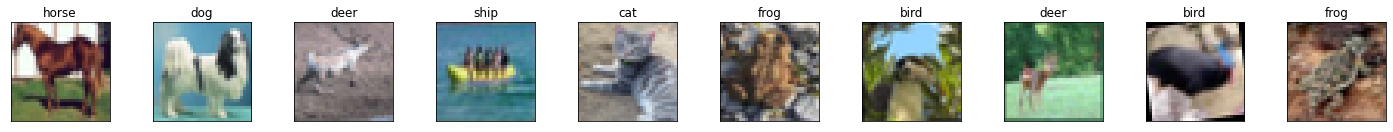

In [12]:
 def imshow(img):
        img = img / 2 + 0.5  # unnormalize
        plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def showImagesfromdataset(dataiterator, classes):
        images, labels = dataiterator.next()
        images = images.numpy()  # convert images to numpy for display

        # plot the images in the batch, along with the corresponding labels
        fig = plt.figure(figsize=(25, 4))
        # display 20 images
        for i in range(len(classes)):
          # for idx in np.arange(5):


          
            ax = fig.add_subplot(2, 20 / 2, i + 1, xticks=[], yticks=[])
            imshow(images[i])
            ax.set_title(classes[labels[i]])

showImagesfromdataset(dataiter,classes)

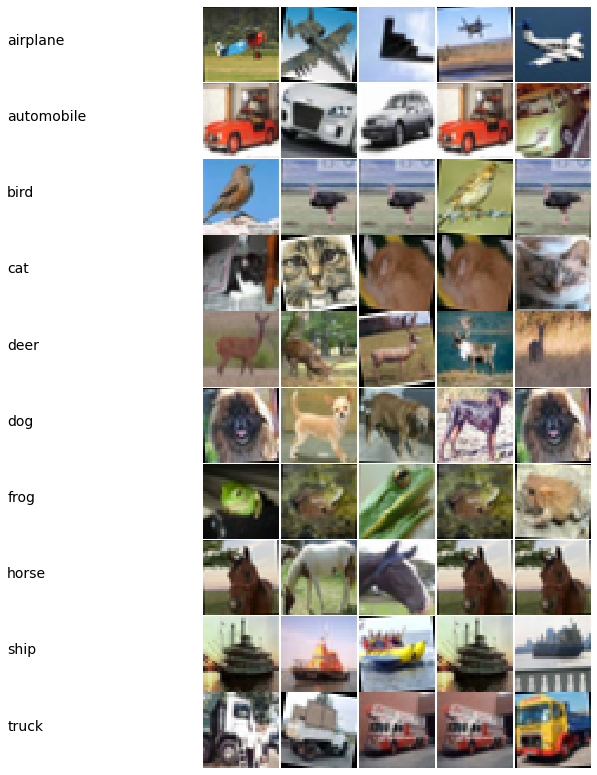

In [13]:
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i] # if not unnormalized then the resulting images will be dark and not visible
  return np.transpose(img, (1,2,0))


num_classes = 10
# display 10 images from each category. 
class_names = ('airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck')

r, c = 10, 10
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1) # (10, 10, i*10+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1) # (10, 10, i*10+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [14]:
#Model Summary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

In [0]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch


class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, trainloader, optimizer, epoch,scheduler, criterion, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = criterion(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, testloader,filename, criterion, correct_samples, correctLabels, incorrect_samples):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0

      with torch.no_grad(): # setting gradients back to zero
          for data, target in testloader:

            img_batch = data # this is done to store data
            data, target = data.to(device), target.to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  

            # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  
            test_loss = criterion(output, target).item()


            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()  
            
            # storing the entire result data as binary
            result = pred.eq(target.view_as(pred))

            # This is to extract incorrect samples/misclassified images
            if len(incorrect_samples) < 25:
              for i in range(0, testloader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})


            # this is to extract correct samples/classified images
            if len(correct_samples) < 25:
              for i in range(0, testloader.batch_size):
                if list(result)[i]:
                  correct_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})
                  correctLabels.append(list(target.view_as(pred))[i]) # this is for gradcam
                
      self.test_losses.append(test_loss)      

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min,test_loss ))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))
    
      self.test_acc.append(100. * correct / len(testloader.dataset))



In [0]:
import torch.nn as nn
from torchsummary import summary
import torch


def cross_entropy_loss():
    """Create Cross Entropy Loss
    Returns:
        Cross entroy loss function
    """
    return nn.CrossEntropyLoss()

def model_summary(model, input_size=(3,32,32)):
	"""
	Returns Summary of the model passed in as model
	"""
	return summary(model, input_size)


 
#Visualization Functions
import matplotlib.pyplot as plt
import numpy as np
import torch


# Display Images from training dataset
def plotImage(img):
    img = img / 2 + 0.5  # unnormalize this is make sure the image is visible, if this step is skipped then the resulting images have a dark portion
    npimg = img.numpy()   # converting image to numpy array format
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    # transposing npimg array





# Misclassified Images
from google.colab import files
def misclassifiedOnes(model, testLoader, data,filename):

  #model: ModelName
  #data: Incorrect Classes in Test() of Test_Train class
  #filename: Pass on the filename with which you want to save misclassified images
  
  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # classs names in the dataset

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model = model.to(device)
  dataiter = iter(testLoader) 
  count = 0
  
  # Initialize plot
  fig = plt.figure(figsize=(13,13))
  
  row_count = -1
  fig, axs = plt.subplots(5, 5, figsize=(10, 10))
  fig.tight_layout()

  for idx, result in enumerate(data):

    # If 25 samples have been stored, break out of loop
    if idx > 24:
      break
        
    rgb_image = np.transpose(result['image'], (1, 2, 0)) / 2 + 0.5
    label = result['label'].item()
    prediction = result['prediction'].item()

    # Plot image
    if idx % 5 == 0:
      row_count += 1
    axs[row_count][idx % 5].axis('off')
    axs[row_count][idx % 5].set_title(f'Label: {classes[label]}\nPrediction: {classes[prediction]}')
    axs[row_count][idx % 5].imshow(rgb_image)
    
  # save the plot
  plt.savefig(filename)
  files.download(filename)


# Correctly Classified Images
from google.colab import files
def correctlyClassifed(model, testLoader, data,filename):

  #model: ModelName
  #data: Correct Classes in Test() of Test_Train class
  #filename: Pass on the filename with which you want to save misclassified images
  
  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # classs names in the dataset

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model = model.to(device)
  dataiter = iter(testLoader) 
  count = 0
  
  # Initialize plot
  fig = plt.figure(figsize=(13,13))
  
  row_count = -1
  fig, axs = plt.subplots(5, 5, figsize=(10, 10))
  fig.tight_layout()

  for idx, result in enumerate(data):

    # If 25 samples have been stored, break out of loop
    if idx > 24:
      break
        
    rgb_image = np.transpose(result['image'], (1, 2, 0)) / 2 + 0.5
    label = result['label'].item()
    prediction = result['prediction'].item()

    # Plot image
    if idx % 5 == 0:
      row_count += 1
    axs[row_count][idx % 5].axis('off')
    axs[row_count][idx % 5].set_title(f'Label: {classes[label]}\nPrediction: {classes[prediction]}')
    axs[row_count][idx % 5].imshow(rgb_image)
    
  # save the plot
  plt.savefig(filename)
  files.download(filename)


In [17]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = ResNet18().to(device)


criterion = cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(trainLoader), epochs = 25)

model1 = Test_Train()
EPOCHS = 25

for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(model, device, trainLoader, optimizer, epoch, scheduler, criterion, L1lambda = 1e-5 )

  model1.test(model, device, testLoader, 'model1.pt', criterion, correctSamples, correctLabels, incorrectSamples )

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  1


Loss=2.2801523208618164 Batch_id=390 Accuracy=48.81: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.0224).  Saving model ...

Test set: Average loss: 1.0224, Accuracy: 5384/10000 (53.84%)

EPOCH:  2


Loss=1.8784823417663574 Batch_id=390 Accuracy=67.48: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.0224 --> 0.8463).  Saving model ...

Test set: Average loss: 0.8463, Accuracy: 6431/10000 (64.31%)

EPOCH:  3


Loss=1.8278815746307373 Batch_id=390 Accuracy=74.64: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.8463 --> 0.4456).  Saving model ...

Test set: Average loss: 0.4456, Accuracy: 6766/10000 (67.66%)

EPOCH:  4


Loss=1.3360657691955566 Batch_id=390 Accuracy=78.81: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4591, Accuracy: 7747/10000 (77.47%)

EPOCH:  5


Loss=1.3370423316955566 Batch_id=390 Accuracy=81.83: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2469, Accuracy: 6968/10000 (69.68%)

EPOCH:  6


Loss=1.0382416248321533 Batch_id=390 Accuracy=84.11: 100%|██████████| 391/391 [00:31<00:00, 12.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8592, Accuracy: 7842/10000 (78.42%)

EPOCH:  7


Loss=1.0662827491760254 Batch_id=390 Accuracy=85.51: 100%|██████████| 391/391 [00:31<00:00, 12.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2727, Accuracy: 7705/10000 (77.05%)

EPOCH:  8


Loss=0.9399306774139404 Batch_id=390 Accuracy=86.91: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.4456 --> 0.2306).  Saving model ...

Test set: Average loss: 0.2306, Accuracy: 8074/10000 (80.74%)

EPOCH:  9


Loss=1.239493727684021 Batch_id=390 Accuracy=88.35: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4869, Accuracy: 8104/10000 (81.04%)

EPOCH:  10


Loss=0.9277447462081909 Batch_id=390 Accuracy=89.57: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.2306 --> 0.0587).  Saving model ...

Test set: Average loss: 0.0587, Accuracy: 8016/10000 (80.16%)

EPOCH:  11


Loss=0.8950186967849731 Batch_id=390 Accuracy=90.55: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5732, Accuracy: 8051/10000 (80.51%)

EPOCH:  12


Loss=1.0167335271835327 Batch_id=390 Accuracy=91.27: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6575, Accuracy: 8054/10000 (80.54%)

EPOCH:  13


Loss=0.7978672981262207 Batch_id=390 Accuracy=91.96: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2656, Accuracy: 8310/10000 (83.10%)

EPOCH:  14


Loss=0.8532528877258301 Batch_id=390 Accuracy=92.89: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4837, Accuracy: 8403/10000 (84.03%)

EPOCH:  15


Loss=0.9505994319915771 Batch_id=390 Accuracy=93.32: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7603, Accuracy: 8233/10000 (82.33%)

EPOCH:  16


Loss=0.7818812727928162 Batch_id=390 Accuracy=94.55: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2741, Accuracy: 8349/10000 (83.49%)

EPOCH:  17


Loss=0.7786529064178467 Batch_id=390 Accuracy=95.21: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3253, Accuracy: 8234/10000 (82.34%)

EPOCH:  18


Loss=0.6014999747276306 Batch_id=390 Accuracy=95.86: 100%|██████████| 391/391 [00:32<00:00, 12.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2020, Accuracy: 8613/10000 (86.13%)

EPOCH:  19


Loss=0.5807545781135559 Batch_id=390 Accuracy=96.82: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0905, Accuracy: 8439/10000 (84.39%)

EPOCH:  20


Loss=0.5691192150115967 Batch_id=390 Accuracy=97.72: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.8420, Accuracy: 8704/10000 (87.04%)

EPOCH:  21


Loss=0.48765134811401367 Batch_id=390 Accuracy=98.66: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2434, Accuracy: 8828/10000 (88.28%)

EPOCH:  22


Loss=0.4415322244167328 Batch_id=390 Accuracy=99.39: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0767, Accuracy: 8891/10000 (88.91%)

EPOCH:  23


Loss=0.4766062796115875 Batch_id=390 Accuracy=99.70: 100%|██████████| 391/391 [00:31<00:00, 12.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.0587 --> 0.0297).  Saving model ...

Test set: Average loss: 0.0297, Accuracy: 8949/10000 (89.49%)

EPOCH:  24


Loss=0.4127121567726135 Batch_id=390 Accuracy=99.79: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7289, Accuracy: 8958/10000 (89.58%)

EPOCH:  25


Loss=0.41260021924972534 Batch_id=390 Accuracy=99.82: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]



Test set: Average loss: 0.9896, Accuracy: 8957/10000 (89.57%)



In [0]:
from torch.nn import functional as F
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers 
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
          def forward_hook(module, input, output): # this will return Input & Output of  a layer during Forward Pass
              self.fmap_pool[key] = output.detach() # 

          return forward_hook

        def save_grads(key):
          def backward_hook(module, grad_in, grad_out): # this will return Input & Output of a layer during Backward Pass
              self.grad_pool[key] = grad_out[0].detach() # 

          return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name))) # appending I/P & O/P of a layer during forward pass
                self.handlers.append(module.register_backward_hook(save_grads(name))) # same during backward pass

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)  # creating a one hot tensor of self.nll shape, but filled with zeros  
        print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0) # replacing ids with 1.0 at dim = 1
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size duign forward pass
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam




In [0]:
def gcam(images, labels, model, target_layers):
  model.eval()

  # map input to device
  images = torch.stack(images).to(device)

  # set up gradcam
  gc = GradCAM(model, target_layers)

  # forward pass
  probs, ids = gc.forward(images)

  # outputs against which to calculate gradients
  ids_ = torch.LongTensor(labels).view(len(images), -1).to(device)

  # backward pass
  gc.backward(ids = ids_)
  layers = []


  for i in range(len(target_layers)):
    targetLayer = target_layers[i]
    print('GENERATING GRADCAM AT ', targetLayer)

    # GRADCAM
    layers.append(gc.generate(target_layer = targetLayer))

  # remove hooks when done
  gc.remove_hook()
  return layers, probs, ids

def plotGCAM(gcam_layers, img, labels, target_layers, class_names, image_size, predicted, unnormalize):
  colum = len(images) + 1
  row = len(target_layers) + 2
  fig = plt.figure(figsize = (30, 15))
  fig.subplots_adjust(hspace = 0.01, wspace = 0.01)
  ax = plt.subplot(row, colum, 1)
  ax.text(0.3, -0.5, 'Input', fontsize = 14)
  plt.axis('off') 
  
  for i in range(len(target_layers)):
    targetLayer = target_layers[i]
    ax = plt.subplot(r, c, c*(i+1)+1)
    ax.text(0.3, -0.5, targetLayer, fontsize = 14)
    plt.axis('off')
    
    for j in range(len(images)):
      img = np.uint8(255*unnormalize(images[j].view(image_size)))
      if i==0:
        ax = plt.subplot(r, c, j+2)
        co = {class_names[predicted[j][0]]}#\n[actual{class_names[labels[j]]}])
        ax.text(0, 1, c, fontsize=14)
        plt.axis('off')
        plt.subplot(r, c, c+j+2)
        plt.imshow(img, interpolation='bilinear')
        plt.axis('off')
      
      heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
      superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
      plt.subplot(r, c, (i+2)*c+j+2)
      plt.imshow(superimposed_img, interpolation='bilinear')
        
      plt.axis('off')
  plt.show()



**GRADCAM**

torch.Size([4, 10])
GENERATING GRADCAM AT  layer1
GENERATING GRADCAM AT  layer2
GENERATING GRADCAM AT  layer3
GENERATING GRADCAM AT  layer4


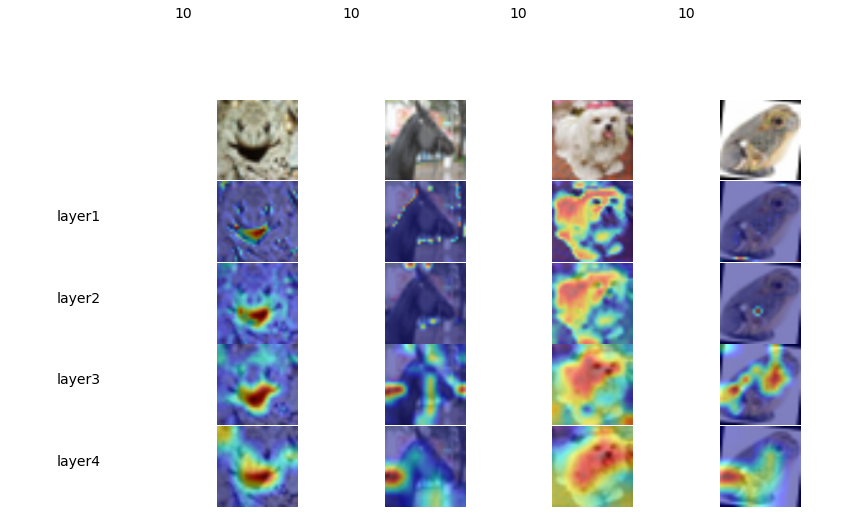

In [70]:


images = [x['image'] for x in random.sample(correctSamples, 4)]

target_classes = [correctLabels[:4]]
# grad_cam(images, 'grad_cam')
model = ResNet18().to(device)
image_size = (3,32,32)

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = gcam(images, target_classes, model, target_layers)
plotGCAM(gradcam_output, images, target_classes, target_layers, class_names, image_size, predicted_classes, unnormalize)
# plotGCAM(gcam_layers, images, labels, target_layers, class_names, image_size, predicted, unnormalize)

In [0]:

dataiter = iter(trainLoader)
images, labels = dataiter.next()
images

In [9]:
import numpy as np
a = np.uint8(9)
type(a)


numpy.uint8